In [1]:
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

def save_labels(arr, filename):
    pd_array = pd.DataFrame(arr)
    pd_array.index.names = ["Id"]
    pd_array.columns = ["Prediction"]
    pd_array.to_csv(filename)

def load_labels(filename):
    return pd.read_csv(filename, index_col=0).values.ravel()

In [2]:


#X_train = np.load("/mnt/dane_ml/X_train.npy")
#y_train = load_labels("/mnt/dane_ml/y_train.csv")
#X_test = np.load("/mnt/dane_ml/X_test.npy")
X_train = np.load("E:\\Desktop\\dane_ml\\X_train.npy")
y_train = load_labels("E:\\Desktop\\dane_ml\\y_train.csv")
X_test = np.load("E:\\Desktop\\dane_ml\\X_test.npy")

# Mój keras ma kolorki na końcu
X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).transpose(0,2,3,1)
X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).transpose(0,2,3,1)


In [3]:
#if not os.path.isfile("baseline.pkl"):
#    lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(verbose=43))])
#    lr.fit(X_train, y_train)
#    print("Train acc:", accuracy_score(y_train, lr.predict(X_train)))
#    with open("baseline.pkl", 'w') as f_out:
#        pickle.dump(lr, f_out)
#else:
#    with open("baseline.pkl", 'r') as f_in:
#        lr = pickle.load(f_in)
#
#save_labels(model.predict(X_test), "y_pred.csv")

In [4]:
import tensorflow as tf

In [5]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))



b'Hello, TensorFlow!'


# CZĘŚĆ PIERWSZA

In [6]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


xgboost?

In [7]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
first_X_train, first_X_test, first_y_train, first_y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=43)
first_y_train = to_categorical(first_y_train, num_classes=10)
first_y_test = to_categorical(first_y_test, num_classes=10)



Using TensorFlow backend.


In [8]:
input_shape=first_X_train[0].shape
print(input_shape)

print(first_y_test[5])

(32, 32, 3)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


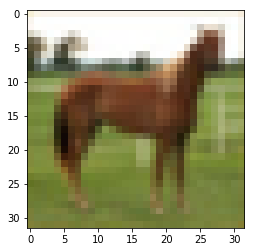

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(first_X_train[54])

In [10]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       73856     
__________

In [12]:
model.fit(first_X_train, first_y_train,
          batch_size=1024,
          epochs=1024,
          verbose=1,
          validation_data=(first_X_test, first_y_test))#first_X_test, first_y_test))


Train on 33500 samples, validate on 16500 samples
Epoch 1/1024
33500/33500 [==============================] - 21s - loss: 2.7870 - acc: 0.1138 - val_loss: 2.3021 - val_acc: 0.1007
Epoch 2/1024
33500/33500 [==============================] - 17s - loss: 2.2965 - acc: 0.1098 - val_loss: 2.3021 - val_acc: 0.1116
Epoch 3/1024
33500/33500 [==============================] - 17s - loss: 2.2990 - acc: 0.1132 - val_loss: 2.3030 - val_acc: 0.1016
Epoch 4/1024
33500/33500 [==============================] - 17s - loss: 2.2997 - acc: 0.1099 - val_loss: 2.2856 - val_acc: 0.1416
Epoch 5/1024
33500/33500 [==============================] - 17s - loss: 2.2823 - acc: 0.1254 - val_loss: 2.3092 - val_acc: 0.1010
Epoch 6/1024
33500/33500 [==============================] - 17s - loss: 2.3060 - acc: 0.1044 - val_loss: 2.2860 - val_acc: 0.1521
Epoch 7/1024
33500/33500 [==============================] - 17s - loss: 2.2860 - acc: 0.1174 - val_loss: 2.3038 - val_acc: 0.0952
Epoch 8/1024
33500/33500 [==============

33500/33500 [==============================] - 17s - loss: 0.1558 - acc: 0.9508 - val_loss: 1.0571 - val_acc: 0.7586
Epoch 126/1024
33500/33500 [==============================] - 17s - loss: 0.1317 - acc: 0.9576 - val_loss: 1.0747 - val_acc: 0.7600
Epoch 127/1024
33500/33500 [==============================] - 17s - loss: 0.1359 - acc: 0.9591 - val_loss: 1.0838 - val_acc: 0.7595
Epoch 128/1024
33500/33500 [==============================] - 17s - loss: 0.1335 - acc: 0.9586 - val_loss: 1.0725 - val_acc: 0.7566
Epoch 129/1024
33500/33500 [==============================] - 17s - loss: 0.1330 - acc: 0.9597 - val_loss: 1.0792 - val_acc: 0.7596
Epoch 130/1024
33500/33500 [==============================] - 17s - loss: 0.1298 - acc: 0.9622 - val_loss: 1.0791 - val_acc: 0.7552
Epoch 131/1024
33500/33500 [==============================] - 17s - loss: 0.1234 - acc: 0.9617 - val_loss: 1.1280 - val_acc: 0.7583
Epoch 132/1024
33500/33500 [==============================] - 17s - loss: 0.1137 - acc: 0.9

33500/33500 [==============================] - 17s - loss: 0.0884 - acc: 0.9760 - val_loss: 1.1900 - val_acc: 0.7634
Epoch 250/1024
33500/33500 [==============================] - 17s - loss: 0.0983 - acc: 0.9720 - val_loss: 1.1170 - val_acc: 0.7654
Epoch 251/1024
33500/33500 [==============================] - 16s - loss: 0.0883 - acc: 0.9747 - val_loss: 1.1492 - val_acc: 0.7580
Epoch 252/1024
33500/33500 [==============================] - 17s - loss: 0.0973 - acc: 0.9721 - val_loss: 1.1503 - val_acc: 0.7608
Epoch 253/1024
33500/33500 [==============================] - 17s - loss: 0.1193 - acc: 0.9669 - val_loss: 1.0785 - val_acc: 0.7633
Epoch 254/1024
33500/33500 [==============================] - 17s - loss: 0.1188 - acc: 0.9664 - val_loss: 1.2275 - val_acc: 0.7484
Epoch 255/1024
33500/33500 [==============================] - 16s - loss: 0.1125 - acc: 0.9683 - val_loss: 1.1150 - val_acc: 0.7625
Epoch 256/1024
33500/33500 [==============================] - 17s - loss: 0.0969 - acc: 0.9

33500/33500 [==============================] - 17s - loss: 0.0847 - acc: 0.9791 - val_loss: 1.2571 - val_acc: 0.7687
Epoch 374/1024
33500/33500 [==============================] - 17s - loss: 0.0887 - acc: 0.9772 - val_loss: 1.2708 - val_acc: 0.7610
Epoch 375/1024
33500/33500 [==============================] - 17s - loss: 0.0926 - acc: 0.9753 - val_loss: 1.1932 - val_acc: 0.7692
Epoch 376/1024
33500/33500 [==============================] - 17s - loss: 0.0807 - acc: 0.9801 - val_loss: 1.2334 - val_acc: 0.7652
Epoch 377/1024
33500/33500 [==============================] - 17s - loss: 0.0894 - acc: 0.9778 - val_loss: 1.2911 - val_acc: 0.7656
Epoch 378/1024
33500/33500 [==============================] - 17s - loss: 0.1033 - acc: 0.9744 - val_loss: 1.2962 - val_acc: 0.7575
Epoch 379/1024
33500/33500 [==============================] - 17s - loss: 0.1161 - acc: 0.9721 - val_loss: 1.2487 - val_acc: 0.7601
Epoch 380/1024
33500/33500 [==============================] - 17s - loss: 0.0967 - acc: 0.9

33500/33500 [==============================] - 17s - loss: 0.0805 - acc: 0.9799 - val_loss: 1.3105 - val_acc: 0.7654
Epoch 498/1024
33500/33500 [==============================] - 17s - loss: 0.0905 - acc: 0.9769 - val_loss: 1.2728 - val_acc: 0.7688
Epoch 499/1024
33500/33500 [==============================] - 17s - loss: 0.0866 - acc: 0.9796 - val_loss: 1.3424 - val_acc: 0.7680
Epoch 500/1024
33500/33500 [==============================] - 17s - loss: 0.0823 - acc: 0.9803 - val_loss: 1.3737 - val_acc: 0.7668
Epoch 501/1024
33500/33500 [==============================] - 17s - loss: 0.0940 - acc: 0.9767 - val_loss: 1.3146 - val_acc: 0.7685
Epoch 502/1024
33500/33500 [==============================] - 17s - loss: 0.0834 - acc: 0.9789 - val_loss: 1.3448 - val_acc: 0.7713
Epoch 503/1024
33500/33500 [==============================] - 17s - loss: 0.1036 - acc: 0.9745 - val_loss: 1.3122 - val_acc: 0.7588
Epoch 504/1024
33500/33500 [==============================] - 17s - loss: 0.1027 - acc: 0.9

33500/33500 [==============================] - 16s - loss: 0.1166 - acc: 0.9728 - val_loss: 1.4543 - val_acc: 0.7717
Epoch 622/1024
33500/33500 [==============================] - 16s - loss: 0.1007 - acc: 0.9784 - val_loss: 1.4739 - val_acc: 0.7690
Epoch 623/1024
33500/33500 [==============================] - 16s - loss: 0.0909 - acc: 0.9790 - val_loss: 1.5106 - val_acc: 0.7618
Epoch 624/1024
33500/33500 [==============================] - 16s - loss: 0.1185 - acc: 0.9745 - val_loss: 1.4713 - val_acc: 0.7663
Epoch 625/1024
33500/33500 [==============================] - 16s - loss: 0.1143 - acc: 0.9751 - val_loss: 1.5297 - val_acc: 0.7658
Epoch 626/1024
33500/33500 [==============================] - 16s - loss: 0.1068 - acc: 0.9767 - val_loss: 1.4758 - val_acc: 0.7665
Epoch 627/1024
33500/33500 [==============================] - 16s - loss: 0.0968 - acc: 0.9775 - val_loss: 1.5034 - val_acc: 0.7687
Epoch 628/1024
33500/33500 [==============================] - 16s - loss: 0.0882 - acc: 0.9

33500/33500 [==============================] - 16s - loss: 0.1339 - acc: 0.9714 - val_loss: 1.5299 - val_acc: 0.7630
Epoch 746/1024
33500/33500 [==============================] - 16s - loss: 0.1181 - acc: 0.9746 - val_loss: 1.5558 - val_acc: 0.7692
Epoch 747/1024
33500/33500 [==============================] - 16s - loss: 0.1004 - acc: 0.9774 - val_loss: 1.5547 - val_acc: 0.7727
Epoch 748/1024
33500/33500 [==============================] - 16s - loss: 0.1087 - acc: 0.9771 - val_loss: 1.6044 - val_acc: 0.7638
Epoch 749/1024
33500/33500 [==============================] - 16s - loss: 0.1084 - acc: 0.9774 - val_loss: 1.5703 - val_acc: 0.7678
Epoch 750/1024
33500/33500 [==============================] - 16s - loss: 0.1086 - acc: 0.9770 - val_loss: 1.5335 - val_acc: 0.7716
Epoch 751/1024
33500/33500 [==============================] - 16s - loss: 0.0991 - acc: 0.9784 - val_loss: 1.5848 - val_acc: 0.7645
Epoch 752/1024
33500/33500 [==============================] - 16s - loss: 0.1119 - acc: 0.9

33500/33500 [==============================] - 16s - loss: 0.1335 - acc: 0.9707 - val_loss: 1.5972 - val_acc: 0.7656
Epoch 870/1024
33500/33500 [==============================] - 16s - loss: 0.1320 - acc: 0.9747 - val_loss: 1.7428 - val_acc: 0.7670
Epoch 871/1024
33500/33500 [==============================] - 16s - loss: 0.1174 - acc: 0.9759 - val_loss: 1.7078 - val_acc: 0.7708
Epoch 872/1024
33500/33500 [==============================] - 16s - loss: 0.1406 - acc: 0.9724 - val_loss: 1.6972 - val_acc: 0.7547
Epoch 873/1024
33500/33500 [==============================] - 16s - loss: 0.1353 - acc: 0.9718 - val_loss: 1.7038 - val_acc: 0.7687
Epoch 874/1024
33500/33500 [==============================] - 16s - loss: 0.1395 - acc: 0.9715 - val_loss: 1.6875 - val_acc: 0.7596
Epoch 875/1024
33500/33500 [==============================] - 16s - loss: 0.1213 - acc: 0.9754 - val_loss: 1.7563 - val_acc: 0.7680
Epoch 876/1024
33500/33500 [==============================] - 16s - loss: 0.1148 - acc: 0.9

33500/33500 [==============================] - 16s - loss: 0.1303 - acc: 0.9738 - val_loss: 1.7521 - val_acc: 0.7618
Epoch 994/1024
33500/33500 [==============================] - 16s - loss: 0.1381 - acc: 0.9731 - val_loss: 1.6815 - val_acc: 0.7632
Epoch 995/1024
33500/33500 [==============================] - 16s - loss: 0.1358 - acc: 0.9713 - val_loss: 1.6853 - val_acc: 0.7657
Epoch 996/1024
33500/33500 [==============================] - 16s - loss: 0.1364 - acc: 0.9724 - val_loss: 1.7755 - val_acc: 0.7528
Epoch 997/1024
33500/33500 [==============================] - 16s - loss: 0.1284 - acc: 0.9752 - val_loss: 1.8632 - val_acc: 0.7603
Epoch 998/1024
33500/33500 [==============================] - 16s - loss: 0.1481 - acc: 0.9724 - val_loss: 1.7664 - val_acc: 0.7580
Epoch 999/1024
33500/33500 [==============================] - 16s - loss: 0.1388 - acc: 0.9731 - val_loss: 1.7573 - val_acc: 0.7663
Epoch 1000/1024
33500/33500 [==============================] - 16s - loss: 0.1331 - acc: 0.

In [14]:
score = model.evaluate(first_X_test, first_y_test, verbose=0)
print(score)

[1.8288915009354101, 0.76406060607505566]


In [16]:
score = model.evaluate(first_X_train, first_y_train, verbose=0)
print(score)

[0.0046945814273375965, 0.99919402985074623]
